In [1]:
from astropy.io import fits
import numpy as np

In [2]:
# Open the calibration file for the vignetting
hdu = fits.open('XRT3_XAREAEF_0012.CCF')

In [3]:
# fov scaling 
fov = 0.6 # None for the default

if fov:
    vignet_name = f'xmm_pn_vignet_{str(fov).replace(".","_") + "_fov"}.fits'
else:
    vignet_name = 'xmm_pn_vignet.fits'


In [4]:
# load the energybins
energy = hdu['VIGNETTING'].data['ENERGY']

# Transform them to the sixte format
energy_lo = np.array(energy[:-1]/1000.0).reshape(1, len(energy[:-1])) # E to keV 
energy_hi = np.array(energy[1:]/1000.0).reshape(1, len(energy[1:])) # # E to keV

In [10]:
# Create the theta step_size bins
theta_stepsize = hdu['VIGNETTING'].header['D_THETA']
theta_bins = hdu['VIGNETTING'].data['VIGNETTING_FACTOR'].shape[1]
if fov:
    # Extend the vignetting untill with some extra theta by doing linear interpolation
    theta_extend = fov/2
    theta_prev = (theta_bins-1)*theta_stepsize
    extra_bins = round((theta_extend-theta_prev)/theta_stepsize)
    theta_bins += extra_bins

theta = [0.0]

# if fov:
#     fov_radius = fov/2.0
#     theta_stepsize = fov_radius/float(theta_bins-1)
    
for i in range(theta_bins-1):
    theta.append(theta[-1] + theta_stepsize)

theta = np.array(theta).reshape(1, len(theta)) # , dtype=[('THETA', '>f4')]
# We do not have a phi, thus an array of zero
phi = np.zeros((1,1)) # , dtype=[('PHI', '>f4')]

In [1]:


# Create the vignet array
vignet = np.zeros((1,theta.shape[1]-1,energy_lo.shape[1])) # , dtype=[('VIGNET', '>f4')]

ccf_vignet_data = hdu['VIGNETTING'].data['VIGNETTING_FACTOR']

for i in range(ccf_vignet_data.shape[0]-1):
    # i indexes the theta variable
    # print(ccf_vignet_data[i][0])
    for j in range(ccf_vignet_data.shape[1]-1):
        # j intexes the energy bin variable
        # Convert to keV
        vignet[0][j][i] = ccf_vignet_data[i][j]

if extra_bins > 0:
    for e in range(vignet.shape[2]):
        # e is for every enery level
        index1 = vignet.shape[1] - extra_bins - 2
        index2 = vignet.shape[1] - extra_bins - 1
        linear_step_size = vignet[0][index2][e] - vignet[0][index1][e]

        for i in range(vignet.shape[1] - extra_bins, vignet.shape[1]):
            vignet[0][i][e] = vignet[0][i-1][e] + linear_step_size
            # print(vignet[0][i][e])

# vignet = vignet.reshape(vignet.shape[::-1])

NameError: name 'np' is not defined

[1.0, 0.9943519830703735, 0.9812589883804321, 0.9612910151481628, 0.9375960230827332, 0.9150170087814331, 0.884909987449646, 0.8547919988632202, 0.8206490278244019, 0.7933930158615112, 0.7582380175590515, 0.7224979996681213, 0.6825240254402161, 0.6475409865379333, 0.6137710213661194, 0.5798100233078003, 0.548088014125824, 0.520484983921051, 0.4943229854106903, 0.4670349955558777, 0.43870100378990173, 0.41349801421165466, 0.3895229995250702, 0.3676320016384125, 0.3504520058631897, 0.3329330086708069, 0.3154140114784241, 0.29789501428604126, 0.28037601709365845, 0.26285701990127563]


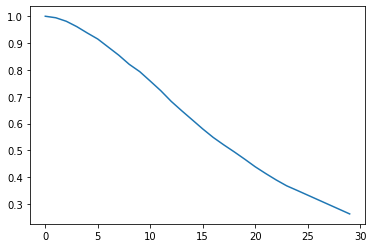

In [13]:
a = [row[10] for row in vignet[0]]
print(a)

import matplotlib.pyplot as plt
plt.plot(a)

In [71]:
# The format is based on: https://heasarc.gsfc.nasa.gov/docs/heasarc/caldb/docs/memos/cal_gen_92_021/cal_gen_92_021.html


energy_lo_col = fits.Column('ENERG_LO', format=f'{energy_lo.shape[1]}E', unit='keV', dim=f'{energy_lo.shape[1]}', array=energy_lo) #, format=f'{len(energy_lo)}E', unit='keV', dim=f'{energy_lo.shape[0]}'
energy_hi_col = fits.Column('ENERG_HI', format=f'{energy_hi.shape[1]}E', unit='keV', dim=f'{energy_hi.shape[1]}', array=energy_hi)
theta_col = fits.Column('THETA', format=f'{theta.shape[1]}E', unit='degree', dim=f'{theta.shape[1]}', array=theta)
phi_col = fits.Column('PHI', format=f'{phi.shape[1]}E', unit='degree', dim=f'{phi.shape[1]}', array=phi)
vignet_col = fits.Column('VIGNET', format=f'{vignet.shape[0]*vignet.shape[1]*vignet.shape[2]}E', dim=f'{vignet.shape[::-1]}', array=vignet) # format=f'{vignet.shape[0]*vignet.shape[1]*vignet.shape[2]}E', dim=f'{vignet.shape[::-1]}',  #dim=f'{vignet.shape[::-1]}'

coldefs = fits.ColDefs([energy_lo_col, energy_hi_col, theta_col, phi_col, vignet_col])
vignet_hdr = fits.Header()
# Include the required headers
vignet_hdr['HDUCLASS'] = 'OGIP'
vignet_hdr['HDUCLAS1'] = 'RESPONSE'
vignet_hdr['HDUVERS1'] = '1.0.0'
vignet_hdr['HDUCLAS2'] = 'VIGNET'
vignet_hdr['HDUVERS2'] = '1.1.0'
vignet_hdr['VERSION'] = '20171016'
vignet_hdr['MISSION'] = 'XMM'
vignet_hdr['TELESCOP'] = 'XMM'
vignet_hdr['DETNAM'] = 'XMM'
vignet_hdr['INSTRUME'] = 'EPN'

vignet_hdr['TUNIT1'] = 'keV'
vignet_hdr['TUNIT2'] = 'keV'
vignet_hdr['TUNIT3'] = 'degree'
vignet_hdr['TUNIT4'] = 'degree'

# vignet_hdr['INSTRUME'] = 'EPIC-PN'
vignet_hdr.add_history('Produced by Sam Sweere (ESAC Trainee) according to data from the XMM-PN calibration file XRT3_XAREAEF_0012.CCF')
vignet_hdu = fits.BinTableHDU.from_columns(coldefs, header=vignet_hdr)
vignet_hdu.name = 'VIGNET'

# Create the final hdul
primary_hdu = fits.PrimaryHDU()
hdul = fits.HDUList([primary_hdu, vignet_hdu])

In [8]:
# Save the new fits file
hdul.writeto(vignet_name, overwrite=True)

In [9]:
hdu_s = hdul
len(hdu_s['VIGNET'].data[0])

for i in range(len(hdu_s['VIGNET'].data[0])):
    print("Dtype name:",hdu_s['VIGNET'].data.dtype.names[i])
    print("Dtype type:",hdu_s['VIGNET'].data.dtype[i])
    print("Values (XMM):")
    print(hdu_s['VIGNET'].data[0][i])
    
    print("-----------")

Dtype name: ENERG_LO
Dtype type: ('<f4', (504,))
Values (XMM):
[ 0.          0.1085      0.1102      0.112       0.1138      0.1156
  0.1175      0.1194      0.1213      0.1233      0.1253      0.12730001
  0.1294      0.1315      0.13360001  0.1358      0.138       0.1402
  0.1425      0.1448      0.1471      0.1495      0.1519      0.15439999
  0.15689999  0.1594      0.162       0.1646      0.1673      0.17
  0.1727      0.1755      0.17830001  0.1812      0.1842      0.18710001
  0.1902      0.19319999  0.19639999  0.1995      0.2028      0.206
  0.2094      0.2128      0.2162      0.2197      0.22330001  0.2269
  0.2305      0.2343      0.2381      0.2419      0.2458      0.2498
  0.2538      0.2579      0.2621      0.26639998  0.2707      0.275
  0.2795      0.284       0.2886      0.29329997  0.298       0.3028
  0.3077      0.3127      0.3178      0.3229      0.3281      0.33339998
  0.33879998  0.3443      0.3499      0.3555      0.3613      0.3671
  0.3731      0.3791      0.